# Introduction to Machine Learning
## Project Phase 2

Sina Fathi | 402111261

Seyyed Amirmahdi Sadrzadeh | 401102015

### Part 1: Data Preproccessing

First we import the needed libraries:

In [4]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import random
from sympy import mod_inverse

Now we use torch library to load the MNIST dataset and then turn them to numpy arrays:

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

# بارگذاری مجموعه داده MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)

X_train_torch = trainset.data
Y_train_torch = trainset.targets

X_train = X_train_torch.numpy()
Y_train = Y_train_torch.numpy()

In [15]:
# بارگذاری مجموعه داده تست
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

# استخراج داده‌ها و برچسب‌ها از مجموعه داده تست
X_test_torch = testset.data
Y_test_torch = testset.targets

# تبدیل داده‌های تست به فرمت NumPy
X_test = X_test_torch.numpy()
Y_test = Y_test_torch.numpy()

# باینارسازی داده‌های تست با آستانه 128
X_test = (X_test > threshold).astype(np.uint32)

# تغییر شکل داده‌ها به اندازه‌ی مناسب برای مدل RBM
X_test_binary = X_test.reshape(-1, 28 * 28)

To use the datas, we binarize them by setting a threshold equal to 128. So all pixels with values higher than 128 will be set to 1 and others will be set to 0. We also flatten the datas to use them in our model:

In [6]:
threshold = 128
X_train = (X_train > threshold).astype(np.uint32)
X_train_binary = X_train.reshape(-1, 28 * 28)

The plot to show the samples:

In [7]:
def show_samples(samples, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].reshape(28, 28), cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

And now we use the above function to show 10 samples from the dataset:

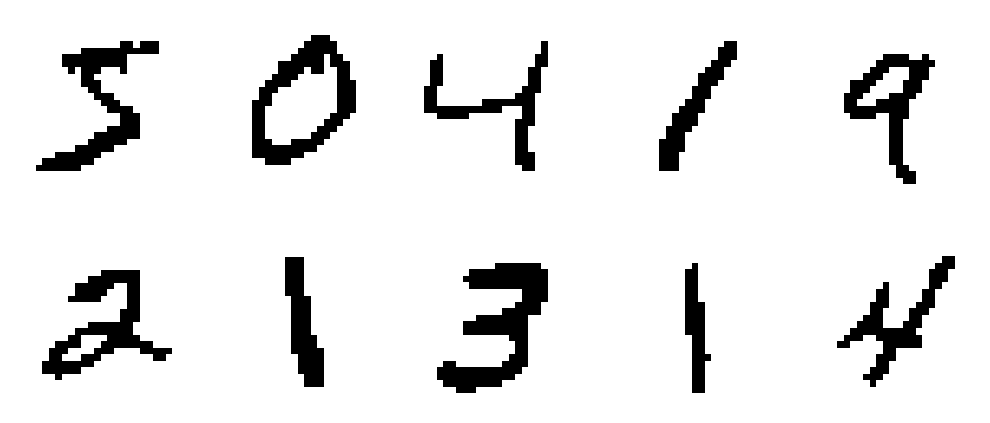

In [8]:
show_samples(X_train_binary[:10])

### Part 2: Implementing the model

Simple Boltzman machine:

In [9]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def gibbs_sampling(self, hid, k):
        v_prob_0 = self.sigmoid(np.dot(hid, self.W.T) + self.v_bias)
        v = self.sample(v_prob_0)
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v = self.sample(v_prob)
        return v

    def contrastive_divergence(self, v, k):
        h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)
        h_sample_0 = self.sample(h_prob_0)

        v_neg = v.copy()

        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob_neg)

        h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)

        positive_grad = np.dot(v.T, h_prob_0)
        negative_grad = np.dot(v_neg.T, h_prob_neg)

        batch_size = v.shape[0]
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob_0 - h_prob_neg, axis=0)

        return v_neg

    def train(self, data, epochs=10, k=1, batch_size=64):
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                v_neg = self.contrastive_divergence(batch, k)
                epoch_loss += np.mean((batch - v_neg) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data):.5f}")

    def generate_samples(self, n_samples=10, k=1):
        samples = []
        for i in range(n_samples):
            sample = np.random.binomial(1, 0.5, self.n_hidden)
            sample = self.gibbs_sampling(sample, k)
            samples.append(sample)
        return np.array(samples)

Training the normal model:

In [13]:
# آموزش ماشین بولتزمن ساده
n_visible = X_train_binary.shape[1]
n_hidden = 32
k_values = [1, 5, 10]
rbms = {}
for k in k_values:
    print(f"Training RBM with k={k}")
    rbm = RBM(n_visible, n_hidden)
    rbm.train(X_train_binary, epochs=10, k=k)
    rbms[k] = rbm

Training RBM with k=1
Epoch 1/10, Loss: 0.00199
Epoch 2/10, Loss: 0.00160
Epoch 3/10, Loss: 0.00152
Epoch 4/10, Loss: 0.00148
Epoch 5/10, Loss: 0.00146
Epoch 6/10, Loss: 0.00145
Epoch 7/10, Loss: 0.00145
Epoch 8/10, Loss: 0.00144
Epoch 9/10, Loss: 0.00144
Epoch 10/10, Loss: 0.00143
Training RBM with k=5
Epoch 1/10, Loss: 0.00220
Epoch 2/10, Loss: 0.00173
Epoch 3/10, Loss: 0.00164
Epoch 4/10, Loss: 0.00158
Epoch 5/10, Loss: 0.00155
Epoch 6/10, Loss: 0.00153
Epoch 7/10, Loss: 0.00152
Epoch 8/10, Loss: 0.00151
Epoch 9/10, Loss: 0.00150
Epoch 10/10, Loss: 0.00149
Training RBM with k=10
Epoch 1/10, Loss: 0.00230
Epoch 2/10, Loss: 0.00181
Epoch 3/10, Loss: 0.00171
Epoch 4/10, Loss: 0.00165
Epoch 5/10, Loss: 0.00162
Epoch 6/10, Loss: 0.00159
Epoch 7/10, Loss: 0.00158
Epoch 8/10, Loss: 0.00156
Epoch 9/10, Loss: 0.00155
Epoch 10/10, Loss: 0.00154


Evaluation for the normal model:

In [16]:
# ارزیابی ماشین بولتزمن ساده

def evaluate_rbm(rbm, data):
    loss = 0
    for i in range(0, len(data), 64):
        batch = data[i:i+64]
        v_neg = rbm.contrastive_divergence(batch, k=1)
        loss += np.mean((batch - v_neg) ** 2)
    avg_loss = loss / (len(data) / 64)
    return avg_loss

simple_losses = {}
for k in k_values:
    loss = evaluate_rbm(rbms[k], X_test_binary)
    simple_losses[k] = loss
    print(f"Simple RBM with k={k} Test Loss: {loss:.5f}")

Simple RBM with k=1 Test Loss: 0.09083
Simple RBM with k=5 Test Loss: 0.08867
Simple RBM with k=10 Test Loss: 0.08849


The Secure Boltzman Machine:

In [19]:
class SecureRBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1, p=467):
        """
        سازنده کلاس SecureRBM.

        پارامترها:
        - n_visible: تعداد نورون‌های ورودی (معمولاً تعداد پیکسل‌های تصویر).
        - n_hidden: تعداد نورون‌های لایه مخفی.
        - learning_rate: نرخ یادگیری برای به‌روزرسانی وزن‌ها و بایاس‌ها.
        - p: عدد اول برای الگوریتم رمزنگاری ElGamal.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))  # وزن‌ها
        self.v_bias = np.zeros(n_visible)  # بایاس نورون‌های ورودی
        self.h_bias = np.zeros(n_hidden)  # بایاس نورون‌های مخفی
        self.p = p  # عدد اول برای ElGamal

    def sigmoid(self, x):
        """
        تابع سیگموید.
        """
        return 1 / (1 + np.exp(-x))

    def sample(self, prob):
        """
        نمونه‌گیری باینری بر اساس احتمال داده شده.

        پارامترها:
        - prob: آرایه‌ای از احتمالات.

        بازگشت:
        - آرایه‌ای از نمونه‌های باینری (0 یا 1).
        """
        return (np.random.uniform(size=prob.shape) < prob).astype(np.int32)

    def generate_keys(self):
        """
        تولید کلیدهای عمومی و خصوصی با استفاده از الگوریتم ElGamal.

        بازگشت:
        - public_key: یک تاپل شامل (p, g, y).
        - private_key: کلید خصوصی x.
        """
        g = random.randint(2, self.p - 2)
        x = random.randint(1, self.p - 2)
        y = pow(g, x, self.p)
        return (self.p, g, y), x

    def encrypt(self, public_key, message):
        """
        رمزنگاری یک پیام با استفاده از کلید عمومی.

        پارامترها:
        - public_key: تاپل (p, g, y).
        - message: پیام عددی برای رمزنگاری.

        بازگشت:
        - ciphertext: یک تاپل (c1, c2).
        """
        p, g, y = public_key
        k = random.randint(1, p - 2)
        c1 = pow(g, k, p)
        c2 = (message * pow(y, k, p)) % p
        return (c1, c2)

    def decrypt_partial(self, private_key, public_key, ciphertext):
        """
        رمزگشایی جزئی یک پیام رمزنگاری شده با استفاده از کلید خصوصی.

        پارامترها:
        - private_key: کلید خصوصی x.
        - public_key: تاپل (p, g, y).
        - ciphertext: تاپل (c1, c2).

        بازگشت:
        - partially_decrypted: تاپل (c2, s) که در آن s = c1^x mod p.
        """
        p, g, y = public_key
        c1, c2 = ciphertext
        s = pow(c1, private_key, p)
        return (c2, s)

    def decrypt_final(self, partially_decrypted, shared_secret, p):
        """
        رمزگشایی نهایی یک پیام با استفاده از رمزگشایی جزئی و معکوس مقداری مشترک.

        پارامترها:
        - partially_decrypted: تاپل (c2, s).
        - shared_secret: مقدار s.
        - p: عدد اول p.

        بازگشت:
        - message: پیام اصلی بازگشایی شده.
        """
        c2, s = partially_decrypted
        s_inv = mod_inverse(s, p)
        message = (c2 * s_inv) % p
        return message

    def sample_hidden_secure(self, v, public_key, private_key_a, random_r):
        """
        نمونه‌گیری مخفی به صورت امن با استفاده از رمزنگاری ElGamal.

        پارامترها:
        - v: آرایه‌ای از نورون‌های ورودی.
        - public_key: کلید عمومی.
        - private_key_a: کلید خصوصی پارتی A.
        - random_r: مقدار تصادفی برای امنیت بیشتر.

        بازگشت:
        - h_sample: نمونه‌گیری باینری نورون‌های مخفی.
        """
        activation = np.dot(v, self.W) + self.h_bias  # محاسبه فعال‌سازی
        activation_sum = activation.sum(axis=1)  # جمع فعال‌سازی‌ها برای هر نمونه
        encrypted_activation = [self.encrypt(public_key, a) for a in activation_sum]  # رمزنگاری فعال‌سازی‌ها
        decrypted = [self.decrypt_final(self.decrypt_partial(private_key_a, public_key, c), s, self.p)
                     for c, s in encrypted_activation]  # رمزگشایی فعال‌سازی‌ها
        final_activation = np.array(decrypted).reshape(-1, 1) - random_r  # اعمال مقدار تصادفی
        p_h = self.sigmoid(final_activation)  # محاسبه احتمال
        return self.sample(p_h)  # نمونه‌گیری باینری

    def sample_visible_secure(self, h, public_key, private_key_a, random_r):
        """
        نمونه‌گیری مرئی به صورت امن با استفاده از رمزنگاری ElGamal.

        پارامترها:
        - h: آرایه‌ای از نورون‌های مخفی.
        - public_key: کلید عمومی.
        - private_key_a: کلید خصوصی پارتی A.
        - random_r: مقدار تصادفی برای امنیت بیشتر.

        بازگشت:
        - v_sample: نمونه‌گیری باینری نورون‌های مرئی.
        """
        activation = np.dot(h, self.W.T) + self.v_bias  # محاسبه فعال‌سازی
        activation_sum = activation.sum(axis=1)  # جمع فعال‌سازی‌ها برای هر نمونه
        encrypted_activation = [self.encrypt(public_key, a) for a in activation_sum]  # رمزنگاری فعال‌سازی‌ها
        decrypted = [self.decrypt_final(self.decrypt_partial(private_key_a, public_key, c), s, self.p)
                     for c, s in encrypted_activation]  # رمزگشایی فعال‌سازی‌ها
        final_activation = np.array(decrypted).reshape(-1, 1) - random_r  # اعمال مقدار تصادفی
        p_v = self.sigmoid(final_activation)  # محاسبه احتمال
        return self.sample(p_v)  # نمونه‌گیری باینری

    def reconstruct(self, v, public_key_a, private_key_a, random_r):
        """
        بازسازی داده‌های ورودی به صورت امن.

        پارامترها:
        - v: آرایه‌ای از نورون‌های ورودی.
        - public_key_a: کلید عمومی پارتی A.
        - private_key_a: کلید خصوصی پارتی A.
        - random_r: مقدار تصادفی برای امنیت بیشتر.

        بازگشت:
        - v_recon: بازسازی داده‌های ورودی.
        """
        h = self.sample_hidden_secure(v, public_key_a, private_key_a, random_r)  # نمونه‌گیری مخفی
        v_recon = self.sample_visible_secure(h, public_key_a, private_key_a, random_r)  # نمونه‌گیری مرئی
        return v_recon

    def contrastive_divergence_secure(self, v, k, public_key_a, private_key_a, random_r):
        """
        انجام روش Contrastive Divergence به صورت امن.

        پارامترها:
        - v: آرایه‌ای از نورون‌های ورودی.
        - k: تعداد مراحل Gibbs Sampling.
        - public_key_a: کلید عمومی پارتی A.
        - private_key_a: کلید خصوصی پارتی A.
        - random_r: مقدار تصادفی برای امنیت بیشتر.

        بازگشت:
        - v_neg: نمونه‌گیری منفی داده‌های ورودی.
        """
        # مرحله مثبت
        h_prob_0 = self.sigmoid(np.dot(v, self.W) + self.h_bias)
        h_sample_0 = self.sample(h_prob_0)

        # مرحله منفی
        v_neg = v.copy()
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)
            h_sample = self.sample(h_prob)
            v_prob_neg = self.sigmoid(np.dot(h_sample, self.W.T) + self.v_bias)
            v_neg = self.sample(v_prob_neg)

        h_prob_neg = self.sigmoid(np.dot(v_neg, self.W) + self.h_bias)

        # گرادیان مثبت و منفی
        positive_grad = np.dot(v.T, h_prob_0)
        negative_grad = np.dot(v_neg.T, h_prob_neg)

        # به‌روزرسانی وزن‌ها و بایاس‌ها
        batch_size = v.shape[0]
        self.W += self.learning_rate * (positive_grad - negative_grad) / batch_size
        self.v_bias += self.learning_rate * np.mean(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.mean(h_prob_0 - h_prob_neg, axis=0)

        return v_neg

    def train_secure(self, data, epochs=10, k=1, batch_size=64, public_key_a=None, private_key_a=None):
        """
        آموزش مدل SecureRBM به صورت امن.

        پارامترها:
        - data: داده‌های آموزشی به صورت NumPy array.
        - epochs: تعداد دورهای آموزش.
        - k: تعداد مراحل Gibbs Sampling.
        - batch_size: اندازه هر دسته داده.
        - public_key_a: کلید عمومی پارتی A.
        - private_key_a: کلید خصوصی پارتی A.
        """
        for epoch in range(epochs):
            np.random.shuffle(data)
            epoch_loss = 0
            for batch_start in range(0, len(data), batch_size):
                batch = data[batch_start:batch_start + batch_size]
                # تولید مقدار تصادفی r برای هر دسته
                random_r = np.random.randint(1, self.p, size=(batch.shape[0], 1))
                # بازسازی داده‌ها
                v_recon = self.reconstruct(batch, public_key_a, private_key_a, random_r)
                # محاسبه خطا
                loss = np.mean((batch - v_recon) ** 2)
                epoch_loss += loss
                # به‌روزرسانی پارامترها با استفاده از Contrastive Divergence امن
                self.contrastive_divergence_secure(batch, k, public_key_a, private_key_a, random_r)
            avg_loss = epoch_loss / (len(data) / batch_size)
            print(f"Epoch {epoch + 1}/{epochs}, Secure Loss: {avg_loss:.5f}")

    def generate_samples(self, n_samples=10, k=1, public_key_a=None, private_key_a=None):
        """
        تولید نمونه‌های جدید با استفاده از مدل آموزش‌دیده.

        پارامترها:
        - n_samples: تعداد نمونه‌های تولید شده.
        - k: تعداد مراحل Gibbs Sampling برای هر نمونه.
        - public_key_a: کلید عمومی پارتی A.
        - private_key_a: کلید خصوصی پارتی A.

        بازگشت:
        - samples: آرایه‌ای از نمونه‌های تولید شده.
        """
        samples = []
        for _ in range(n_samples):
            # شروع با یک حالت تصادفی برای نورون‌های ورودی
            v = np.random.binomial(1, 0.5, self.n_visible).reshape(1, -1)
            random_r = np.random.randint(1, self.p, size=(1, 1))
            for _ in range(k):
                h = self.sample_hidden_secure(v, public_key_a, private_key_a, random_r)
                v = self.sample_visible_secure(h, public_key_a, private_key_a, random_r)
            samples.append(v.flatten())
        return np.array(samples)


Training the Secure Model:

In [21]:
# آموزش ماشین بولتزمن امن
# تولید کلیدها برای پارتی A و B
# ایجاد یک نمونه از SecureRBM
secure_rbm = SecureRBM(n_visible, n_hidden, learning_rate=0.1, p=467)

# تولید کلیدهای ElGamal برای پارتی A
public_key_a, private_key_a = secure_rbm.generate_keys()

# آموزش ماشین بولتزمن امن
print("Training Secure RBM with k=1")
secure_rbm.train_secure(X_train_binary, epochs=10, k=1, batch_size=64,
                        public_key_a=public_key_a, private_key_a=private_key_a)

Training Secure RBM with k=1


TypeError: cannot unpack non-iterable int object

Evaluating the secure model:

In [18]:
# ارزیابی ماشین بولتزمن امن
def evaluate_secure_rbm(secure_rbm, data, public_key_a, private_key_a, public_key_b, private_key_b, batch_size=64):
    loss = 0.0
    num_batches = len(data) // batch_size
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        # ایجاد یک مقدار تصادفی r برای هر دسته
        random_r = np.random.randint(1, secure_rbm.p, size=(batch.shape[0], 1))

        # بازسازی داده‌ها با استفاده از متدهای امن
        v_recon = secure_rbm.reconstruct(batch, public_key_a, private_key_a, public_key_b, private_key_b, random_r)

        # محاسبه خطا بین داده‌های اصلی و بازسازی شده
        loss += np.mean((batch - v_recon) ** 2)

    avg_loss = loss / num_batches
    return avg_loss

# ارزیابی ماشین بولتزمن امن
secure_loss = evaluate_secure_rbm(
    secure_rbm,
    X_test_binary,
    public_key_a,
    private_key_a,
    public_key_b,
    private_key_b,
    batch_size=64
)
print(f"Secure RBM Test Loss: {secure_loss:.5f}")

AttributeError: 'SecureRBM' object has no attribute 'contrastive_divergence'

Comparison:

In [ ]:
print("مقایسه عملکرد ماشین بولتزمن ساده و امن:")
print(f"Simple RBM with k=1 Test Loss: {simple_losses[1]:.5f}")
print(f"Simple RBM with k=5 Test Loss: {simple_losses[5]:.5f}")
print(f"Simple RBM with k=10 Test Loss: {simple_losses[10]:.5f}")
print(f"Secure RBM Test Loss: {secure_loss:.5f}")